<a href="https://colab.research.google.com/github/khpankiv/Kaggle_learning/blob/trained/ell_feedback_regres_1_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**For using in Colab**

# **Setup**

In [1]:
#A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 498.0 MB 12 kB/s 
     |████████████████████████████████| 5.8 MB 25.4 MB/s 
     |████████████████████████████████| 462 kB 56.3 MB/s 
     |████████████████████████████████| 1.4 MB 55.9 MB/s 


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

# **Read the datasets**

In [3]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c feedback-prize-english-language-learning
!mkdir ELL
! unzip feedback-prize-english-language-learning.zip -d ELL

Saving kaggle.json to kaggle.json
  0% 0.00/2.80M [00:00<?, ?B/s]
100% 2.80M/2.80M [00:00<00:00, 122MB/s]
Archive:  feedback-prize-english-language-learning.zip
  inflating: ELL/sample_submission.csv  
  inflating: ELL/test.csv            
  inflating: ELL/train.csv           


In [4]:
#test= pd.read_csv("./ELL/test.csv")
#test_sub=pd.read_csv("./ELL/sample_submission.csv")

In [34]:
train= pd.read_csv("./ELL/train.csv")
#to make dataset smaller))
#train = train.sample(frac = 0.5)
#test = train.iloc[:,0:2]
#test_sub = train.iloc[:,[0,2]]

Data preprocessing: changing grades into integer

Change grades from [1, 1.5, 2.....4.5, 5] to [0,1,2,3,4,5...8]

And select only grades for cohesion

In [35]:
num_text = train.shape[0]
columns = ['text_id','cohesion']
train_X = train[:].full_text.values
train_Y = (train.iloc[:,2].values)*2-2
#  uncomment for one-hot
#train_Y = tf.keras.utils.to_categorical(train_Y) 
#test_X = train_X
test_id = train.text_id.values
test_Y = (train.iloc[:,2].values)

Calculate the frequency of each grade to balance waightes while training

In [36]:
distribution = train['cohesion']. value_counts(1).sort_index()
distr = dict(zip(range(9), 1/distribution.values))

In [37]:
del train

# **Define the model**
A simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense with Softmax output and a Dropout layer.

Add BERT models

In [9]:
tfhub_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/2"

Fine tune BERT embedding

In [10]:
batch_size = 1

In [44]:
def build_classifier_model(activ,num_output):
  input = tf.keras.layers.Input(shape=(), dtype=tf.string, batch_size = batch_size)
  preprocess_model = hub.KerasLayer(tfhub_preprocess)
  encoder_inputs = preprocess_model(input) 
  encoder = hub.KerasLayer(tfhub_encoder, trainable=True)
  outputs = encoder(encoder_inputs)
  output = outputs['pooled_output']
  #output = tf.keras.layers.Dense(256,activation='ReLU')(output)
  #output = tf.keras.layers.Dense(256, activation='ReLU')(output) 
  #output = tf.keras.layers.Dense(256, activation='ReLU')(output)
  #output = tf.keras.layers.Dense(32, activation='ReLU')(output)
  output = tf.keras.layers.Dense(256, activation='ReLU')(output)
  #net_1 = tf.keras.layers.Dropout(0.1)(output_2)
  net_1 = tf.keras.layers.Dense(num_output, activation = activ)(output)
  return tf.keras.Model(input, net_1)

In [45]:
classifier_model = build_classifier_model('softmax',9)

In [46]:
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(1,)]               0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_type_ids':   0           ['input_3[0][0]']                
                                (1, 128),                                                         
                                 'input_word_ids':                                                
                                (1, 128),                                                         
                                 'input_mask': (1,                                                
                                128)}                                                       

# **Model training**

In [14]:
   # from google3.third_party.tensorflow.core.protobuf import rewriter_config_pb2
    #    config_proto = tf.ConfigProto()
#    off = rewriter_config_pb2.RewriterConfig.OFF
 #   config_proto.graph_options.rewrite_options.arithmetic_optimization = off
  #    session = tf.Session(config=config_proto)

In [47]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(),
                         loss = loss,
                         metrics = 'accuracy')

In [16]:
#board = tf.keras.callbacks.TensorBoard(log_dir='./logs')

In [17]:
#restore = tf.keras.callbacks.BackupAndRestore('/ELL')

In [51]:
epochs = 50

In [52]:
history = classifier_model.fit(x = train_X,
                               y = train_Y,
                               epochs = epochs,
                               batch_size=batch_size, 
                               #callbacks=[restore],
                               class_weight = distr,
                               validation_split= 0.1)

Epoch 1/50
3519/3519 [==============================] - 85s 24ms/step - loss: 14.7845 - accuracy: 0.1577 - val_loss: 2.4894 - val_accuracy: 0.0383
Epoch 2/50
3519/3519 [==============================] - 86s 24ms/step - loss: 14.9881 - accuracy: 0.1591 - val_loss: 2.0215 - val_accuracy: 0.1276
Epoch 3/50
3519/3519 [==============================] - 85s 24ms/step - loss: 14.5448 - accuracy: 0.1591 - val_loss: 1.7540 - val_accuracy: 0.2704
Epoch 4/50
3519/3519 [==============================] - 79s 23ms/step - loss: 14.9417 - accuracy: 0.1677 - val_loss: 2.1209 - val_accuracy: 0.1020
Epoch 5/50
3519/3519 [==============================] - 81s 23ms/step - loss: 14.0593 - accuracy: 0.1688 - val_loss: 1.9709 - val_accuracy: 0.1505
Epoch 6/50
3519/3519 [==============================] - 80s 23ms/step - loss: 14.0353 - accuracy: 0.1549 - val_loss: 1.8129 - val_accuracy: 0.1888
Epoch 7/50
3519/3519 [==============================] - 81s 23ms/step - loss: 14.4563 - accuracy: 0.1742 - val_loss: 2

In [ ]:
classifier_model.save('saved_model2')

In [ ]:
!tar -czvf model2.tar.gz saved_model1

saved_model1/
saved_model1/variables/
saved_model1/variables/variables.index
saved_model1/variables/variables.data-00000-of-00001
saved_model1/saved_model.pb
saved_model1/assets/
saved_model1/keras_metadata.pb


In [ ]:
files.download('model2.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Model evaluation**

In [35]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


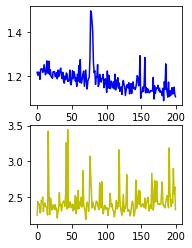

In [36]:
i = range(epochs)
plt.figure(1)
plt.title('Model evaluation')
plt.legend()

#plt.subplot(2,1,1)
#plt.plot(i,history_dict['loss'],'r',label = "Training loss")

plt.subplot(2,2,2)
plt.plot(i,history_dict['mse'],'b',label = "Training MSE")

#plt.subplot(2,1,2)
#plt.plot(i,history_dict['val_loss'],'g',label = "Validadion loss")

plt.subplot(2,2,4)
plt.plot(i,history_dict['val_mse'],'y',label = "Validation MSE")

In [ ]:
#t = test_X[0:5]

In [37]:
test_Y_n = classifier_model.predict(output,verbose = 1)

123/123 [==============================] - 0s 1ms/step


In [38]:
#for classificatio
#pred_test_Y=(np.argmax(test_Y_n,1)+2)/2
#for regression
pred_Y = np.reshape((np.round(test_Y_n)+2)/2,num_text)
mcrmse_test = np.sqrt(np.sum(np.square(pred_Y-test_Y))/num_text)
print('MCRMSE = ',mcrmse_test) 

MCRMSE =  0.5867038663116837


MCRMSE =  0.617284905504784 5 epochs

MCRMSE =  0.6333342304873718 10 epochs

MCRMSE =  0.6012389019459027 10 epochs bached 32

MCRMSE =  0.6137303634466796 5 epochs batched tuned

MCRMSE =  0.5939521873178615 5 epochs 2 dense
  
MCRMSE =  0.5827963961318415 10 epochs 5 dense

MCRMSE =  0.47713642331475004  1 epoch 3 dense shaped

regression:full +3x128+3x64

MCRMSE =  1.1748504531717312

Epoch 100/100 ====>loss: 21.0348 - mse: 2.3953



regression:full +5x128

MCRMSE =  0.6841

Epochs:300 ======> loss: 16.6 - mse: 1.99




regression:full all layers

MCRMSE =  0.568

Epochs:400 ======> loss: 6.66 - mse: 1.03


# **create output file**

In [ ]:
#np.reshape(pred_Y,(num_text))
result = [test_id, pred_Y]
df_result = pd.DataFrame(np.transpose(result),columns = columns)

clear the /kaggle/working

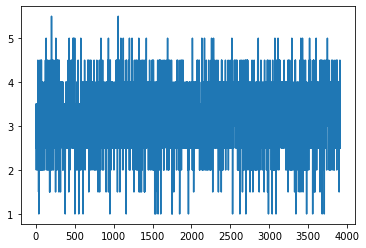

In [ ]:
i = range(num_text)
plt.plot(i,df_result['cohesion'])

In [ ]:
df_result.to_csv('/kaggle/working/submission.csv')